In [2]:
!pip install --quiet soundfile
!pip install --quiet librosa
!pip install --quiet tqdm
!pip install --quiet seaborn
!pip install --quiet scikit-learn

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as Models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm

In [ ]:
RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)
Device = torch.device("cuda")

In [ ]:
def LoadMetaFromDirectory(DataDir):
    meta = []
    for majorCat in os.listdir(DataDir):
        majorPath = os.path.join(DataDir, majorCat)
        if os.path.isdir(majorPath):
            for className in os.listdir(majorPath):
                classPath = os.path.join(majorPath, className)
                if os.path.isdir(classPath):
                    for f in os.listdir(classPath):
                        if f.endswith(".wav"):
                            meta.append({
                                "filename": f,
                                "major_category": majorCat,
                                "class_name": className,
                                "file_path": os.path.join(classPath, f)
                            })
    return pd.DataFrame(meta)

In [ ]:
def PlotClassDistribution(metaDf):
    plt.figure(figsize=(12, 5))
    sns.countplot(data=metaDf, x="class_name", order=metaDf["class_name"].value_counts().index)
    plt.title("Class Distribution in ESC-50 (SequenceMatch Example)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def PlotMajorCategoryDistribution(metaDf):
    plt.figure(figsize=(7, 5))
    sns.countplot(data=metaDf, x="major_category")
    plt.title("Major Category Distribution in ESC-50")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def DisplayRandomAudios(metaDf, numSamples=6):
    subset = metaDf.sample(numSamples, random_state=RandomState)
    fig, Axes = plt.subplots(2, numSamples, figsize=(22, 8))
    
    for i, (_, row) in enumerate(subset.iterrows()):
        fpath = row["file_path"]
        fname = row["filename"]
        cls = row["class_name"]
        majorCat = row["major_category"]

        signal, sr = librosa.load(fpath, sr=None)
        mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        melDb = librosa.power_to_db(mel, ref=np.max)

        Axes[0, i].plot(np.linspace(0,len(signal)/sr,len(signal)), signal)
        Axes[0, i].set_title(f"{fname}\n{cls} ({majorCat})", fontsize=9)
        Axes[0, i].axis("tight")
        img = librosa.display.specshow(melDb, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis", ax=Axes[1, i])
        Axes[1, i].set_title("Mel-Spectrogram", fontsize=9)
        if i == numSamples-1:
            fig.colorbar(img, ax=Axes[1, i], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

In [ ]:
def SplitTrainValTest(metaDf, valRatio=0.1, testRatio=0.1):
    trainRatio = 1.0 - (valRatio + testRatio)
    trainDf, tempDf = train_test_split(
        metaDf,
        test_size=(1-trainRatio),
        stratify=metaDf["class_name"],
        random_state=RandomState
    )
    relValRatio = valRatio / (valRatio + testRatio)
    valDf, testDf = train_test_split(
        tempDf,
        test_size=(1-relValRatio),
        stratify=tempDf["class_name"],
        random_state=RandomState
    )
    return trainDf, valDf, testDf

def FixedCountSplit(trainDf, xPerClass):
    labeledList   = []
    unlabeledList = []
    grouped = trainDf.groupby("class_name")
    for cname, grp in grouped:
        arr = grp.sample(frac=1, random_state=RandomState).values.tolist()
        if len(arr) <= xPerClass:
            labeledList.extend(arr)
        else:
            labeledList.extend(arr[:xPerClass])
            unlabeledList.extend(arr[xPerClass:])
    cols = trainDf.columns.tolist()
    labDf = pd.DataFrame(labeledList, columns=cols)
    unlabDf= pd.DataFrame(unlabeledList, columns=cols)
    return labDf, unlabDf

In [ ]:
def AddGaussianNoise(signal, noiseFactor=0.05):
    noise = np.random.normal(0,1,len(signal))
    return signal + noiseFactor*noise

def PitchChange(signal, sr, pitchRange=5):
    steps = np.random.uniform(-pitchRange, pitchRange)
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=steps)

def SpecAugment(melSpec, timeMask=20, freqMask=10):
    mel = melSpec.copy()
    if mel.shape[1] > timeMask:
        t0 = np.random.randint(0, mel.shape[1]-timeMask)
        mel[:, t0:t0+timeMask]=0
    if mel.shape[0] > freqMask:
        f0 = np.random.randint(0, mel.shape[0]-freqMask)
        mel[f0:f0+freqMask,:]=0
    return mel

def Cutout(melSpec, numHoles=8, holeSize=(5,5)):
    mel = melSpec.copy()
    H,W = mel.shape
    for _ in range(numHoles):
        ry = np.random.randint(0,H-holeSize[0])
        rx = np.random.randint(0,W-holeSize[1])
        mel[ry:ry+holeSize[0], rx:rx+holeSize[1]] = 0
    return mel

In [ ]:
def AudioWeakAugmentation(signal, sr):
    which = random.choice(["weak_pitch","weak_noise"])
    if which=="weak_pitch":
        signal = PitchChange(signal, sr, pitchRange=2)
    else:
        signal = AddGaussianNoise(signal, noiseFactor=0.02)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melDb= librosa.power_to_db(mel, ref=np.max)
    return melDb

def AudioMediumAugmentation(signal, sr):
    signal = PitchChange(signal, sr, pitchRange=3)
    signal = AddGaussianNoise(signal, noiseFactor=0.03)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melDb= librosa.power_to_db(mel, ref=np.max)
    melDb= SpecAugment(melDb, timeMask=15, freqMask=7)
    return melDb

def AudioStrongAugmentation(signal, sr):
    which = random.choice(["big_pitch","heavy_noise"])
    if which=="big_pitch":
        signal = PitchChange(signal, sr, pitchRange=6)
    else:
        signal = AddGaussianNoise(signal, noiseFactor=0.06)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    melDb= librosa.power_to_db(mel, ref=np.max)
    scnd = random.choice(["spec_aug","cutout"])
    if scnd=="spec_aug":
        melDb= SpecAugment(melDb, timeMask=25, freqMask=12)
    else:
        melDb= Cutout(melDb, numHoles=10, holeSize=(5,5))
    return melDb

In [ ]:
class AudioSequenceMatchDataset(Dataset):
    def __init__(self, df, isUnlabeled=False):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.isUnlabeled = isUnlabeled
        self.classes = sorted(df["class_name"].unique())
        self.classToIdx = {c: i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fpath = row["file_path"]
        cname = row["class_name"]
        label = self.classToIdx[cname]
        if self.isUnlabeled:
            label = -1

        sig,sr = librosa.load(fpath, sr=None)

        melOrig = librosa.feature.melspectrogram(y=sig, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        melOrigDb= librosa.power_to_db(melOrig, ref=np.max)
        origT = torch.tensor(melOrigDb, dtype=torch.float).unsqueeze(0)

        melWeakDb = AudioWeakAugmentation(sig, sr)
        weakT= torch.tensor(melWeakDb, dtype=torch.float).unsqueeze(0)

        melMedDb = AudioMediumAugmentation(sig, sr)
        medT= torch.tensor(melMedDb, dtype=torch.float).unsqueeze(0)

        melStrDb= AudioStrongAugmentation(sig, sr)
        strT= torch.tensor(melStrDb, dtype=torch.float).unsqueeze(0)

        return {
            "Original": origT,
            "Weak": weakT,
            "Medium": medT,
            "Strong": strT,
            "Label": label
        }

In [ ]:
class AudioTestDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.classes = sorted(df["class_name"].unique())
        self.classToIdx = {c: i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fpath = row["file_path"]
        cname = row["class_name"]
        label= self.classToIdx[cname]

        sig,sr = librosa.load(fpath, sr=None)
        mel = librosa.feature.melspectrogram(y=sig, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        melDb= librosa.power_to_db(mel, ref=np.max)

        melT= torch.tensor(melDb, dtype=torch.float).unsqueeze(0)
        return melT,label

In [ ]:
class AudioDenseNet(nn.Module):
    def __init__(self, numClasses=50, dropoutProb=0.0):
        super().__init__()
        self.backbone = Models.densenet121(weights=Models.DenseNet121_Weights.DEFAULT)
        self.backbone.features.conv0= nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        nn.init.kaiming_normal_(self.backbone.features.conv0.weight, mode='fan_out', nonlinearity='relu')

        nfeats = self.backbone.classifier.in_features
        self.dropout = nn.Dropout(p=dropoutProb) if dropoutProb>0 else nn.Identity()
        self.classifier = nn.Linear(nfeats, numClasses)

    def forward(self, x):
        x = self.backbone.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x,(1,1))
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
def TrainSequenceMatchAudio(
    model,
    labeledLoader,
    unlabeledLoader,
    valLoader,
    testLoader,
    realClasses,
    numEpochs=20,
    lr=0.01,
    tau=0.95,
    lambdaU=0.8,
    klWeight=0.1,
    eps=1e-8,
    runName="SequenceRun"
):
    device=Device
    numClasses = len(realClasses)
    model = model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler= torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=numEpochs)

    trainLossList=[]
    trainSupLossList=[]
    trainUnsupLossList=[]
    trainAccList=[]
    valLossList=[]
    valAccList=[]

    for ep in range(numEpochs):
        model.train()
        totalLoss=0.0
        supLossSum=0.0
        unsupLossSum=0.0
        correctSup=0
        totalSup=0
        nBatches=0

        unIter = iter(unlabeledLoader)

        for lbBatch in tqdm(labeledLoader, desc=f"{runName} E{ep+1}/{numEpochs}", leave=False):
            lw = lbBatch["Weak"].float().to(device)
            labs= lbBatch["Label"].to(device).long()

            outL= model(lw)
            supLoss= F.cross_entropy(outL, labs)

            predsL= torch.argmax(outL, dim=1)
            correctSup += (predsL==labs).sum().item()
            totalSup   += labs.size(0)

            try:
                ub= next(unIter)
            except StopIteration:
                unIter= iter(unlabeledLoader)
                ub= next(unIter)

            wU= ub["Weak"].float().to(device)
            mU= ub["Medium"].float().to(device)
            sU= ub["Strong"].float().to(device)

            with torch.no_grad():
                outWeak= model(wU)
                distWeak= F.softmax(outWeak, dim=1)

            maxProbs, hardLabel= torch.max(distWeak, dim=1)
            hiConfMask= (maxProbs>=tau).float()

            outMed= model(mU)
            distMed= F.softmax(outMed, dim=1)

            outStr= model(sU)
            distStr= F.softmax(outStr, dim=1)

            T=0.5
            wSharp= distWeak**(1./T)
            wSharp= wSharp/(wSharp.sum(dim=1, keepdim=True)+eps)

            ceHard= F.cross_entropy(outStr, hardLabel, reduction="none")
            logStr= F.log_softmax(outStr,dim=1)
            ceSoft= -(wSharp*logStr).sum(dim=1)

            unsupCE= hiConfMask*ceHard + (1.-hiConfMask)*ceSoft
            unsupCE= unsupCE.mean()

            def kl_div(p,q):
                return (p*(p.add(eps).log()-q.add(eps).log())).sum(dim=1)

            wSharpDet= wSharp.detach()
            KL_w_m= hiConfMask * kl_div(wSharpDet, distMed)
            KL_m_s= hiConfMask * kl_div(distMed, distStr)
            KL_w_s= hiConfMask * kl_div(wSharpDet, distStr)

            KL_w_m= KL_w_m.mean()
            KL_m_s= KL_m_s.mean()
            KL_w_s= KL_w_s.mean()

            sumKL= (KL_w_m+KL_m_s+KL_w_s)*klWeight
            unsupLoss= unsupCE+ sumKL
            unsupLossScaled= lambdaU*unsupLoss

            totalBatchLoss= supLoss+ unsupLossScaled

            optimizer.zero_grad()
            totalBatchLoss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            optimizer.step()

            totalLoss+= totalBatchLoss.item()
            supLossSum+= supLoss.item()
            unsupLossSum+= unsupLoss.item()
            nBatches+=1

        avgTot= totalLoss/nBatches
        avgSup= supLossSum/nBatches
        avgUnsup= unsupLossSum/nBatches
        trainAcc= correctSup/(totalSup+1e-8)

        trainLossList.append(avgTot)
        trainSupLossList.append(avgSup)
        trainUnsupLossList.append(avgUnsup)
        trainAccList.append(trainAcc)

        model.eval()
        valLossVal=0.
        valB=0
        valPreds=[]
        valLabels=[]
        with torch.no_grad():
            for vx,vy in valLoader:
                vx= vx.float().to(device)
                vy= vy.to(device)
                outV= model(vx)
                lv= F.cross_entropy(outV,vy)
                valLossVal+= lv.item()
                valB+=1
                p_ = torch.argmax(outV,dim=1)
                valPreds.extend(p_.cpu().numpy())
                valLabels.extend(vy.cpu().numpy())
        avgValLoss= valLossVal/valB
        valAcc= accuracy_score(valLabels,valPreds)

        valLossList.append(avgValLoss)
        valAccList.append(valAcc)

        print(f"{runName} Epoch[{ep+1}/{numEpochs}] "
              f"TrainLoss={avgTot:.4f}, Sup={avgSup:.4f}, Unsup={avgUnsup:.4f}, TrainAcc={trainAcc*100:.2f}% "
              f"ValLoss={avgValLoss:.4f}, ValAcc={valAcc*100:.2f}%")

        scheduler.step()

    testPreds=[]
    testLabels=[]
    testProbs=[]
    model.eval()
    with torch.no_grad():
        for tx,ty in testLoader:
            tx= tx.float().to(device)
            ty= ty.to(device)
            outT= model(tx)
            pT= F.softmax(outT,dim=1)
            prd= torch.argmax(outT,dim=1)

            testPreds.extend(prd.cpu().numpy())
            testLabels.extend(ty.cpu().numpy())
            testProbs.extend(pT.cpu().numpy())

    testAcc= accuracy_score(testLabels,testPreds)
    oneHot= np.eye(numClasses)[np.array(testLabels)]
    rocA= roc_auc_score(oneHot, np.array(testProbs), multi_class="ovr")
    avgP= average_precision_score(oneHot, np.array(testProbs), average="macro")

    print(f"\n{runName} --- Final Test Results ---")
    print(f"Test Accuracy: {testAcc*100:.2f}%")
    print(f"ROC AUC: {rocA:.4f}, Average Precision (AUC-PRC): {avgP:.4f}")

    print("\nClassification Report:")
    idx2cls= {i:c for i,c in enumerate(realClasses)}
    tgtNames= [idx2cls[i] for i in range(numClasses)]
    print(classification_report(testLabels,testPreds, target_names=tgtNames, zero_division=0))

    saveName= f"SequenceMatch_ESC50_{runName}.pth"
    torch.save(model.state_dict(), saveName)
    print(f"Model weights saved: {saveName}")

    return {
        "TrainLoss": trainLossList,
        "TrainSupLoss": trainSupLossList,
        "TrainUnsupLoss": trainUnsupLossList,
        "TrainAcc": trainAccList,
        "ValLoss": valLossList,
        "ValAcc": valAccList,
        "TestAcc": testAcc,
        "RocAuc": rocA,
        "AvgPrecision": avgP
    }

In [ ]:
def Main():
    dataDir= r"/kaggle/input/esc-50/esc_50"
    metaDf= LoadMetaFromDirectory(dataDir)

    print("=== Dataset Overview ===")
    print(metaDf.head())
    print(f"Total recordings: {len(metaDf)}")
    print(f"Major categories: {metaDf['major_category'].nunique()}")
    print(f"Unique classes:   {metaDf['class_name'].nunique()}")

    print("\nPlotting Class Distribution:")
    PlotClassDistribution(metaDf)

    print("\nPlotting Major Category Distribution:")
    PlotMajorCategoryDistribution(metaDf)

    print("\nRandom Audios (Wave + Mel):")
    DisplayRandomAudios(metaDf, numSamples=3)

    trainDf, valDf, testDf= SplitTrainValTest(metaDf, valRatio=0.1, testRatio=0.1)
    allClasses= sorted(metaDf["class_name"].unique())
    print(f"\nClasses discovered: {allClasses}")

    LabeledCounts= [5,9,17,26]
    resultsDict= {}

    for xCount in LabeledCounts:
        print(f"\n=== SequenceMatch with {xCount} labeled/class ===")
        labDf, unlabDf= FixedCountSplit(trainDf, xCount)

        labDS= AudioSequenceMatchDataset(labDf, isUnlabeled=False)
        unlabDS= AudioSequenceMatchDataset(unlabDf, isUnlabeled=True)
        valDS= AudioTestDataset(valDf)
        tstDS= AudioTestDataset(testDf)

        bsz= 16
        labLoader= DataLoader(labDS, batch_size=bsz, shuffle=True, num_workers=0)
        unlabLoader= DataLoader(unlabDS,batch_size=bsz, shuffle=True, num_workers=0)
        valLoader= DataLoader(valDS, batch_size=bsz, shuffle=False, num_workers=0)
        testLoader=DataLoader(tstDS,batch_size=bsz, shuffle=False, num_workers=0)

        model= AudioDenseNet(numClasses=len(allClasses), dropoutProb=0.2)

        runName= f"{xCount}_PerClass_SeqMatch"
        runRes= TrainSequenceMatchAudio(
            model, 
            labLoader, unlabLoader, valLoader, testLoader, 
            realClasses=allClasses,
            numEpochs=20,
            lr=0.01,
            tau=0.95,
            lambdaU=0.8,
            klWeight=0.1,
            eps=1e-8,
            runName=runName
        )

        epRange= range(1, len(runRes["TrainLoss"])+1)

        plt.figure(figsize=(8,5))
        plt.plot(epRange, runRes["TrainLoss"], label="Total Train Loss", marker="o")
        plt.plot(epRange, runRes["TrainSupLoss"], label="Supervised Loss", marker="o")
        plt.plot(epRange, runRes["TrainUnsupLoss"], label="Unsupervised Loss", marker="o")
        plt.title(f"Training Loss Curves (FC={xCount})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(epRange, runRes["TrainAcc"], label="Train Accuracy", marker="o")
        plt.title(f"Training Accuracy (FC={xCount})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(epRange, runRes["ValLoss"], label="Validation Loss", marker="o", color="red")
        plt.title(f"Validation Loss (FC={xCount})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(epRange, [v*100 for v in runRes["ValAcc"]], label="Val Accuracy (%)", marker="o", color="green")
        plt.title(f"Validation Accuracy (FC={xCount})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(epRange, runRes["TrainLoss"], label="Train Loss", marker="o")
        plt.plot(epRange, runRes["ValLoss"], label="Val Loss", marker="o", color="red")
        plt.title(f"Train vs Val Loss (FC={xCount})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        resultsDict[xCount]= runRes
        print(f"Final Test Accuracy w/ {xCount} labeled/class => {runRes['TestAcc']*100:.2f}%\n")

    print("===== SUMMARY OF RUNS =====")
    for xCount in LabeledCounts:
        tA= resultsDict[xCount]["TestAcc"]*100
        vA= resultsDict[xCount]["ValAcc"][-1]*100
        print(f"{xCount} labeled/class: TestAcc={tA:.2f}% | ValAcc(final)={vA:.2f}%")

=== Dataset Overview ===
           filename major_category class_name  \
0  5-203128-A-0.wav        animals        dog   
1  3-136288-A-0.wav        animals        dog   
2  3-180256-A-0.wav        animals        dog   
3   1-85362-A-0.wav        animals        dog   
4   1-30344-A-0.wav        animals        dog   

                                           file_path  
0  /kaggle/input/esc-50/esc_50/animals/dog/5-2031...  
1  /kaggle/input/esc-50/esc_50/animals/dog/3-1362...  
2  /kaggle/input/esc-50/esc_50/animals/dog/3-1802...  
3  /kaggle/input/esc-50/esc_50/animals/dog/1-8536...  
4  /kaggle/input/esc-50/esc_50/animals/dog/1-3034...  
Total recordings: 2000
Major categories: 5
Unique classes:   50

Plotting Class Distribution:


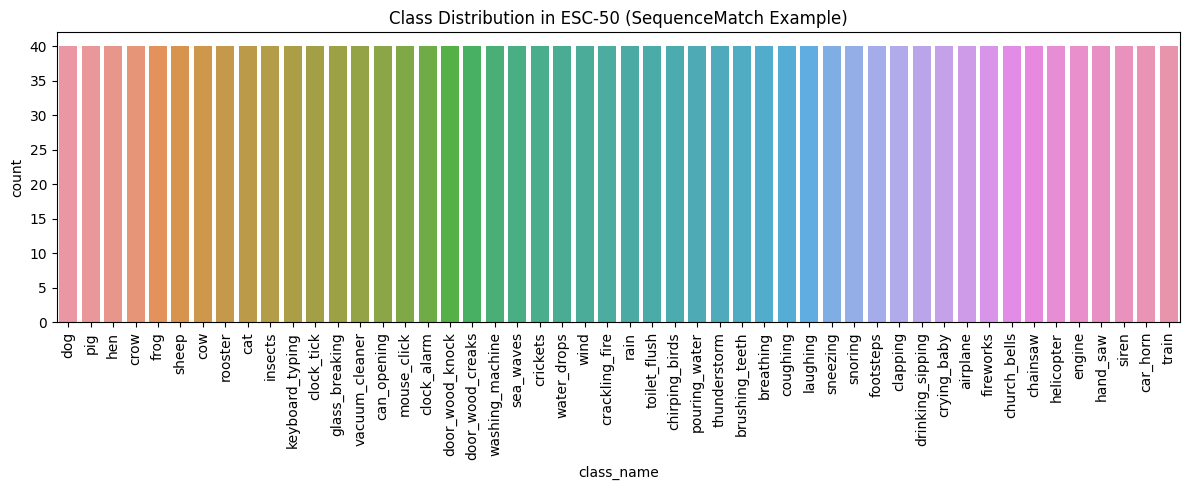


Plotting Major Category Distribution:


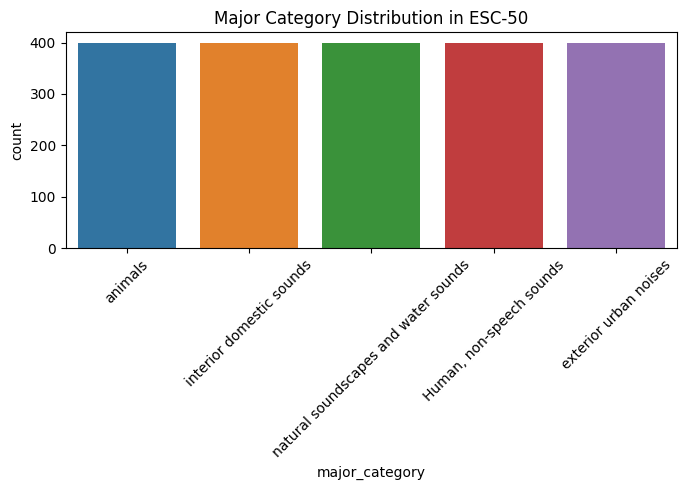


Random Audios (Wave + Mel):


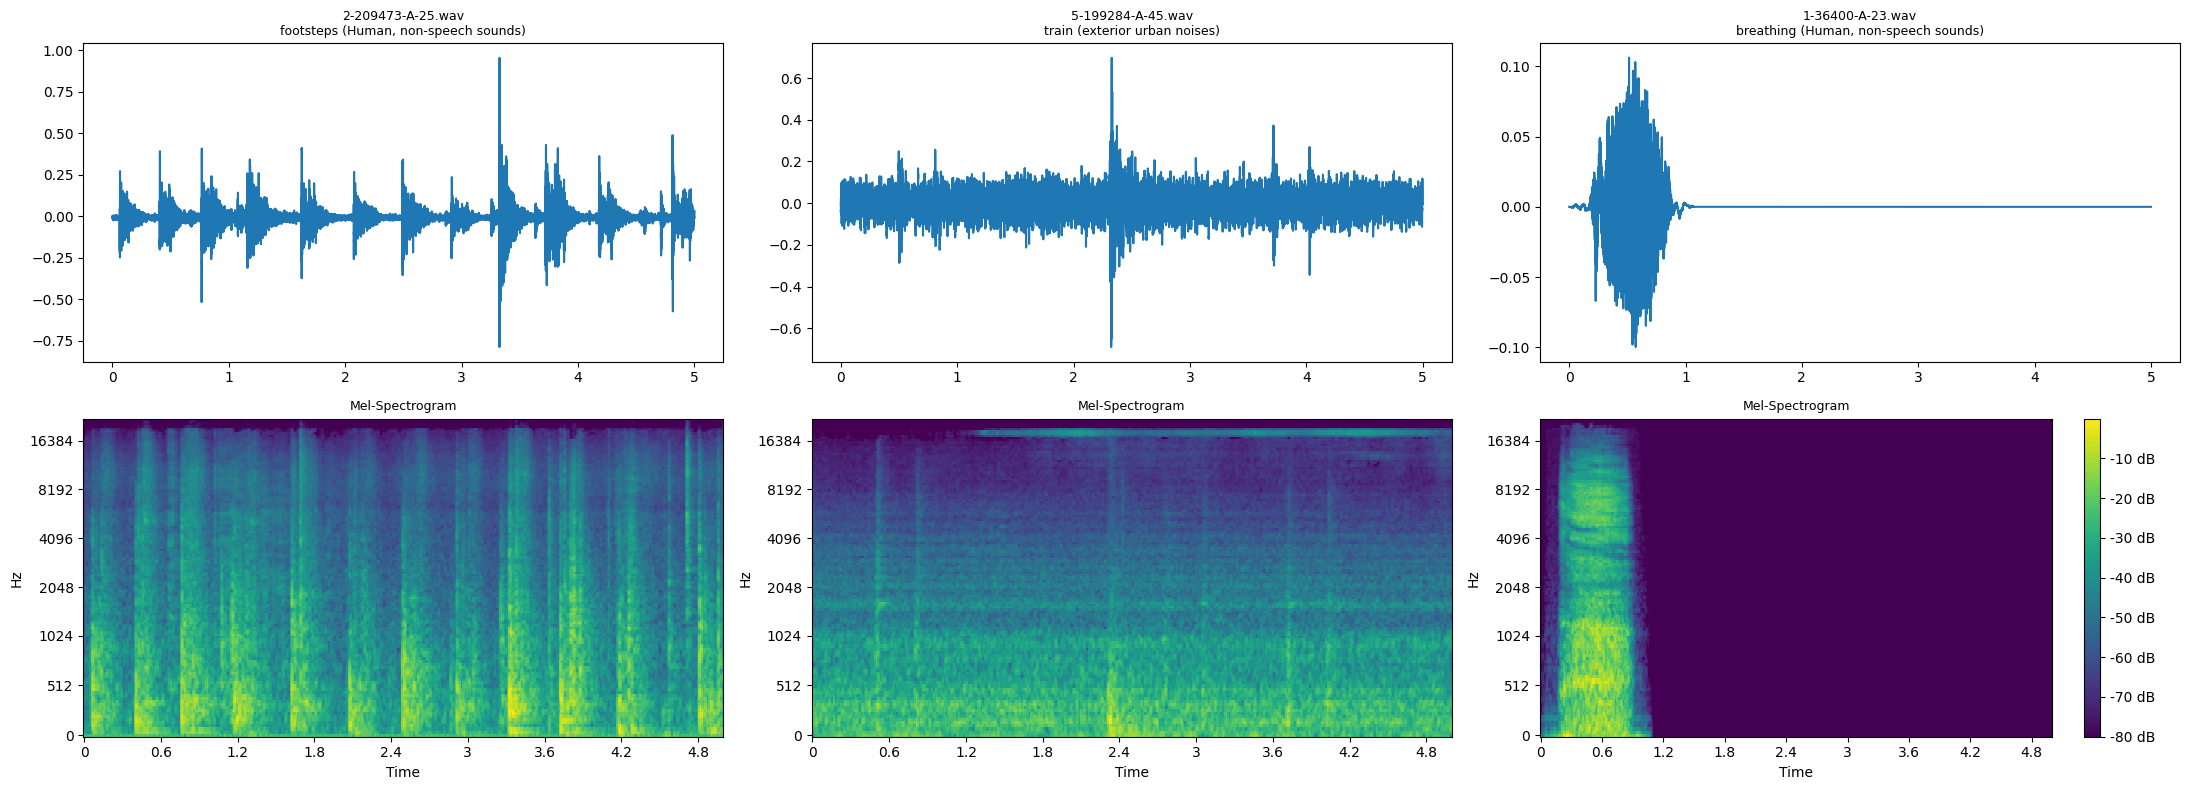


Classes discovered: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']

=== SequenceMatch with 5 labeled/class ===


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 208MB/s]


5_PerClass_SeqMatch Epoch[1/20] TrainLoss=7.1091, Sup=4.0733, Unsup=3.7948, TrainAcc=3.60% ValLoss=3.9543, ValAcc=3.00%


5_PerClass_SeqMatch Epoch[2/20] TrainLoss=6.1346, Sup=4.2287, Unsup=2.3824, TrainAcc=2.80% ValLoss=3.9339, ValAcc=2.00%


5_PerClass_SeqMatch Epoch[3/20] TrainLoss=5.1705, Sup=3.9482, Unsup=1.5278, TrainAcc=2.40% ValLoss=3.7920, ValAcc=3.00%


5_PerClass_SeqMatch Epoch[4/20] TrainLoss=4.6383, Sup=3.3969, Unsup=1.5518, TrainAcc=3.60% ValLoss=3.0610, ValAcc=15.50%


5_PerClass_SeqMatch Epoch[5/20] TrainLoss=4.7154, Sup=2.6274, Unsup=2.6100, TrainAcc=25.20% ValLoss=2.8405, ValAcc=26.00%


5_PerClass_SeqMatch Epoch[6/20] TrainLoss=4.2503, Sup=2.2291, Unsup=2.5266, TrainAcc=35.20% ValLoss=2.4490, ValAcc=39.50%


5_PerClass_SeqMatch Epoch[7/20] TrainLoss=3.4714, Sup=1.6379, Unsup=2.2919, TrainAcc=54.80% ValLoss=2.5773, ValAcc=30.50%


5_PerClass_SeqMatch Epoch[8/20] TrainLoss=3.1753, Sup=1.4386, Unsup=2.1708, TrainAcc=61.20% ValLoss=2.2253, ValAcc=39.50%


5_PerClass_SeqMatch Epoch[9/20] TrainLoss=2.7955, Sup=1.2016, Unsup=1.9924, TrainAcc=66.40% ValLoss=1.9374, ValAcc=49.00%


5_PerClass_SeqMatch Epoch[10/20] TrainLoss=2.4818, Sup=0.8967, Unsup=1.9815, TrainAcc=76.40% ValLoss=2.2046, ValAcc=46.00%


5_PerClass_SeqMatch Epoch[11/20] TrainLoss=2.2493, Sup=0.8342, Unsup=1.7688, TrainAcc=78.80% ValLoss=2.0206, ValAcc=48.00%


5_PerClass_SeqMatch Epoch[12/20] TrainLoss=1.9393, Sup=0.6151, Unsup=1.6551, TrainAcc=85.60% ValLoss=2.1403, ValAcc=47.00%


5_PerClass_SeqMatch Epoch[13/20] TrainLoss=1.8249, Sup=0.6337, Unsup=1.4890, TrainAcc=85.20% ValLoss=1.9909, ValAcc=51.50%


5_PerClass_SeqMatch Epoch[14/20] TrainLoss=1.7939, Sup=0.5447, Unsup=1.5614, TrainAcc=84.80% ValLoss=1.9617, ValAcc=49.00%


5_PerClass_SeqMatch Epoch[15/20] TrainLoss=1.6833, Sup=0.4152, Unsup=1.5850, TrainAcc=90.80% ValLoss=2.0066, ValAcc=50.50%


5_PerClass_SeqMatch Epoch[16/20] TrainLoss=1.5613, Sup=0.3555, Unsup=1.5072, TrainAcc=92.80% ValLoss=1.9686, ValAcc=50.50%


5_PerClass_SeqMatch Epoch[17/20] TrainLoss=1.4713, Sup=0.3093, Unsup=1.4526, TrainAcc=96.00% ValLoss=2.0565, ValAcc=48.50%


5_PerClass_SeqMatch Epoch[18/20] TrainLoss=1.5695, Sup=0.3696, Unsup=1.4999, TrainAcc=92.40% ValLoss=1.9939, ValAcc=51.50%


5_PerClass_SeqMatch Epoch[19/20] TrainLoss=1.6190, Sup=0.3611, Unsup=1.5723, TrainAcc=92.40% ValLoss=1.9396, ValAcc=52.50%


5_PerClass_SeqMatch Epoch[20/20] TrainLoss=1.4912, Sup=0.2572, Unsup=1.5425, TrainAcc=96.80% ValLoss=1.9948, ValAcc=49.50%

5_PerClass_SeqMatch --- Final Test Results ---
Test Accuracy: 56.00%
ROC AUC: 0.9692, Average Precision (AUC-PRC): 0.6750

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00         4
       breathing       0.33      0.25      0.29         4
  brushing_teeth       1.00      0.75      0.86         4
     can_opening       0.75      0.75      0.75         4
        car_horn       1.00      0.25      0.40         4
             cat       0.50      1.00      0.67         4
        chainsaw       0.67      0.50      0.57         4
  chirping_birds       0.25      0.25      0.25         4
    church_bells       0.80      1.00      0.89         4
        clapping       0.25      0.50      0.33         4
     clock_alarm       0.50      0.25      0.33         4
      clock_tick       1.00      

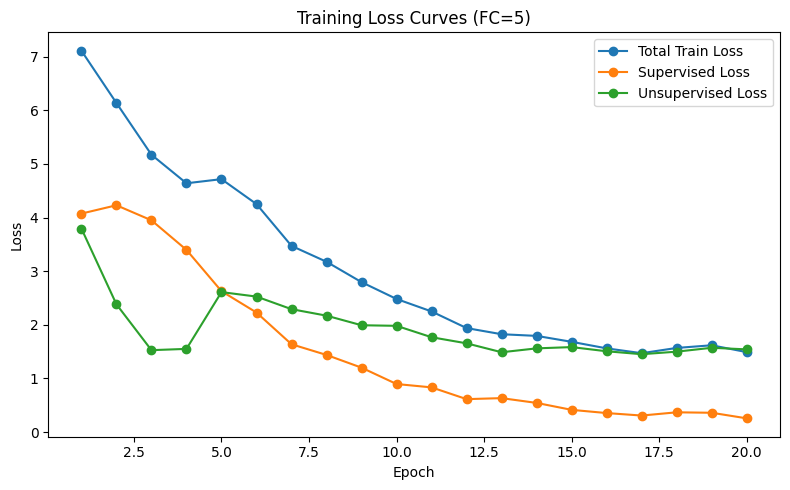

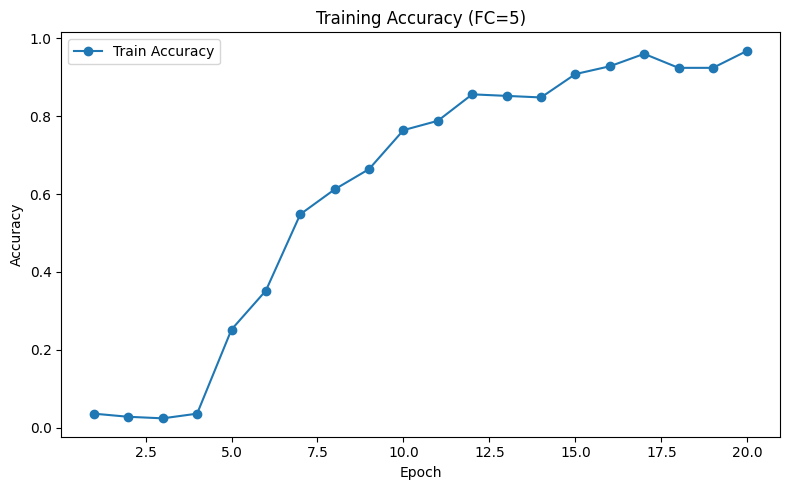

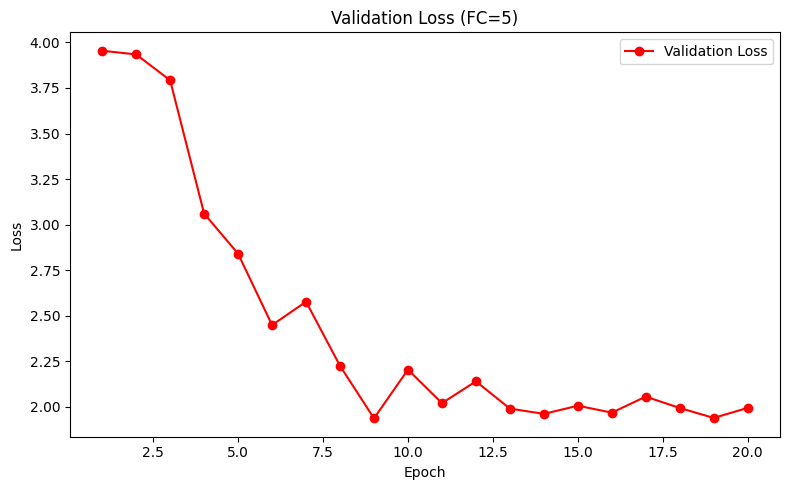

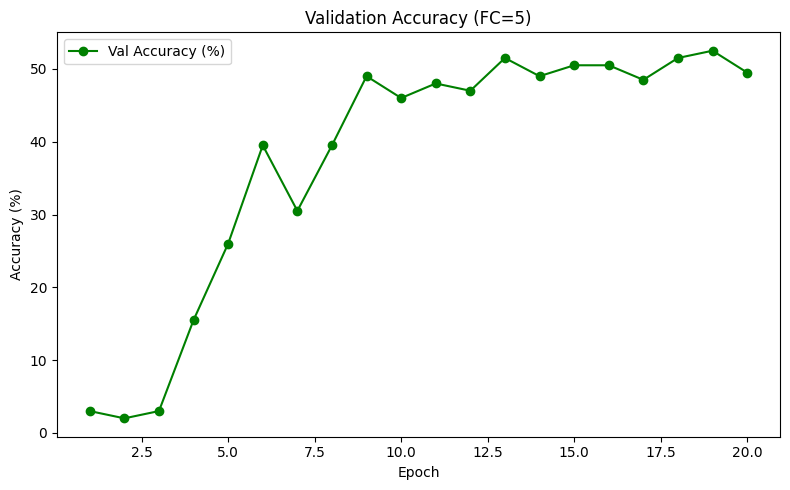

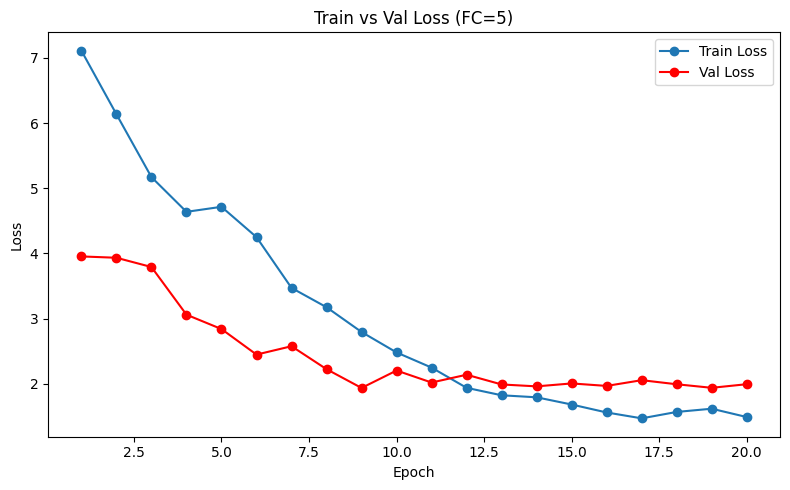

Final Test Accuracy w/ 5 labeled/class => 56.00%


=== SequenceMatch with 9 labeled/class ===


9_PerClass_SeqMatch Epoch[1/20] TrainLoss=6.6020, Sup=4.2390, Unsup=2.9538, TrainAcc=1.33% ValLoss=4.1082, ValAcc=2.00%


9_PerClass_SeqMatch Epoch[2/20] TrainLoss=5.2195, Sup=4.0922, Unsup=1.4091, TrainAcc=2.22% ValLoss=3.4687, ValAcc=6.00%


9_PerClass_SeqMatch Epoch[3/20] TrainLoss=4.8488, Sup=3.1198, Unsup=2.1613, TrainAcc=12.22% ValLoss=2.5979, ValAcc=28.50%


9_PerClass_SeqMatch Epoch[4/20] TrainLoss=4.3573, Sup=2.5081, Unsup=2.3116, TrainAcc=33.78% ValLoss=2.2173, ValAcc=38.50%


9_PerClass_SeqMatch Epoch[5/20] TrainLoss=3.6621, Sup=1.9758, Unsup=2.1079, TrainAcc=43.33% ValLoss=2.0055, ValAcc=43.00%


9_PerClass_SeqMatch Epoch[6/20] TrainLoss=3.1217, Sup=1.5204, Unsup=2.0017, TrainAcc=52.67% ValLoss=1.9333, ValAcc=44.50%


9_PerClass_SeqMatch Epoch[7/20] TrainLoss=2.6624, Sup=1.2837, Unsup=1.7233, TrainAcc=63.11% ValLoss=1.8896, ValAcc=42.00%


9_PerClass_SeqMatch Epoch[8/20] TrainLoss=2.5264, Sup=1.1997, Unsup=1.6585, TrainAcc=66.44% ValLoss=1.6624, ValAcc=55.50%


9_PerClass_SeqMatch Epoch[9/20] TrainLoss=2.1161, Sup=0.9104, Unsup=1.5071, TrainAcc=74.00% ValLoss=1.6600, ValAcc=57.00%


9_PerClass_SeqMatch Epoch[10/20] TrainLoss=1.9634, Sup=0.8047, Unsup=1.4484, TrainAcc=79.11% ValLoss=1.4841, ValAcc=61.50%


9_PerClass_SeqMatch Epoch[11/20] TrainLoss=1.7045, Sup=0.6462, Unsup=1.3228, TrainAcc=83.33% ValLoss=1.5762, ValAcc=59.50%


9_PerClass_SeqMatch Epoch[12/20] TrainLoss=1.6774, Sup=0.6252, Unsup=1.3153, TrainAcc=83.78% ValLoss=1.3297, ValAcc=64.00%


9_PerClass_SeqMatch Epoch[13/20] TrainLoss=1.5836, Sup=0.4800, Unsup=1.3796, TrainAcc=88.89% ValLoss=1.4409, ValAcc=62.50%


9_PerClass_SeqMatch Epoch[14/20] TrainLoss=1.4245, Sup=0.4433, Unsup=1.2265, TrainAcc=89.78% ValLoss=1.3571, ValAcc=65.50%


9_PerClass_SeqMatch Epoch[15/20] TrainLoss=1.2970, Sup=0.4136, Unsup=1.1043, TrainAcc=91.11% ValLoss=1.3253, ValAcc=65.00%


9_PerClass_SeqMatch Epoch[16/20] TrainLoss=1.1746, Sup=0.3733, Unsup=1.0016, TrainAcc=92.67% ValLoss=1.2271, ValAcc=66.00%


9_PerClass_SeqMatch Epoch[17/20] TrainLoss=1.1740, Sup=0.2751, Unsup=1.1237, TrainAcc=96.22% ValLoss=1.2154, ValAcc=67.50%


9_PerClass_SeqMatch Epoch[18/20] TrainLoss=1.1582, Sup=0.2981, Unsup=1.0751, TrainAcc=96.22% ValLoss=1.1600, ValAcc=69.00%


9_PerClass_SeqMatch Epoch[19/20] TrainLoss=1.1039, Sup=0.2534, Unsup=1.0631, TrainAcc=95.11% ValLoss=1.2003, ValAcc=69.00%


9_PerClass_SeqMatch Epoch[20/20] TrainLoss=1.0642, Sup=0.2410, Unsup=1.0290, TrainAcc=97.11% ValLoss=1.1762, ValAcc=68.00%

9_PerClass_SeqMatch --- Final Test Results ---
Test Accuracy: 71.00%
ROC AUC: 0.9862, Average Precision (AUC-PRC): 0.8236

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.50      0.25      0.33         4
       breathing       0.50      0.50      0.50         4
  brushing_teeth       1.00      0.75      0.86         4
     can_opening       0.60      0.75      0.67         4
        car_horn       1.00      0.75      0.86         4
             cat       1.00      1.00      1.00         4
        chainsaw       0.50      1.00      0.67         4
  chirping_birds       0.50      1.00      0.67         4
    church_bells       0.80      1.00      0.89         4
        clapping       1.00      0.25      0.40         4
     clock_alarm       1.00      1.00      1.00         4
      clock_tick       1.00      

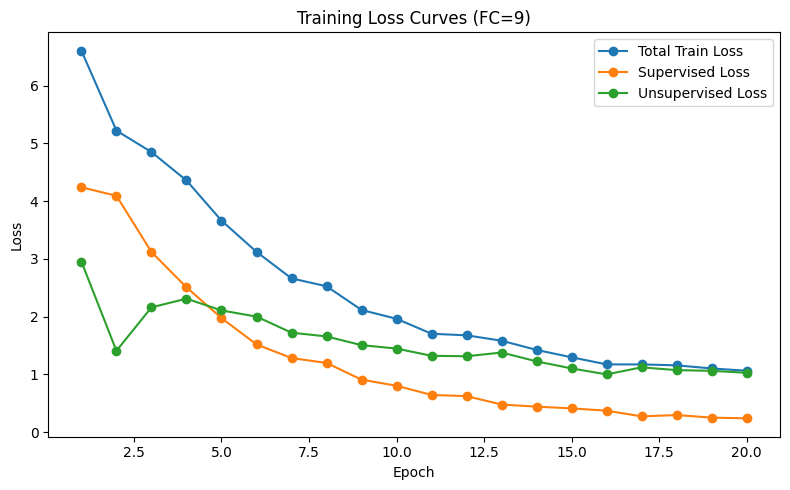

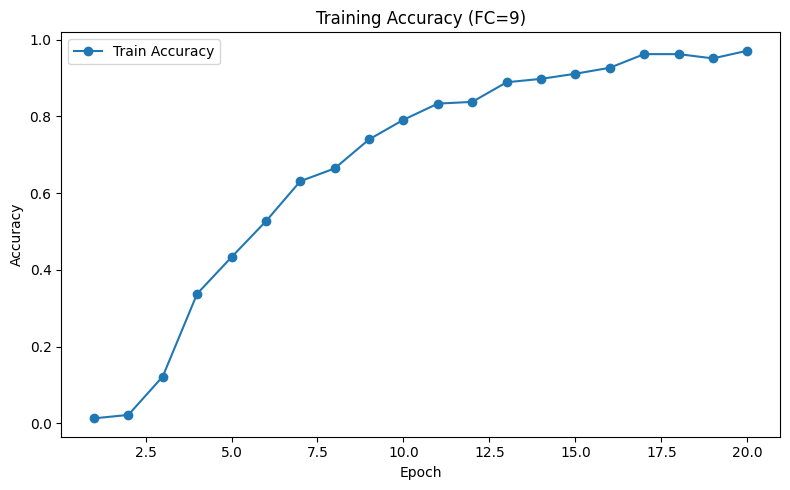

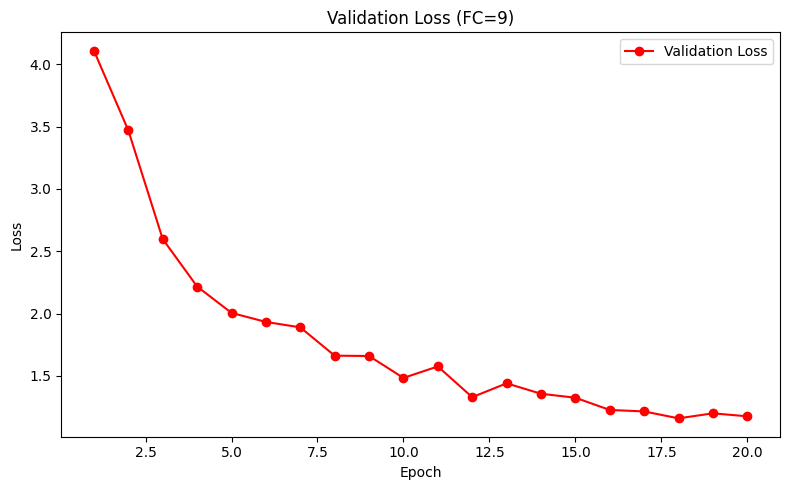

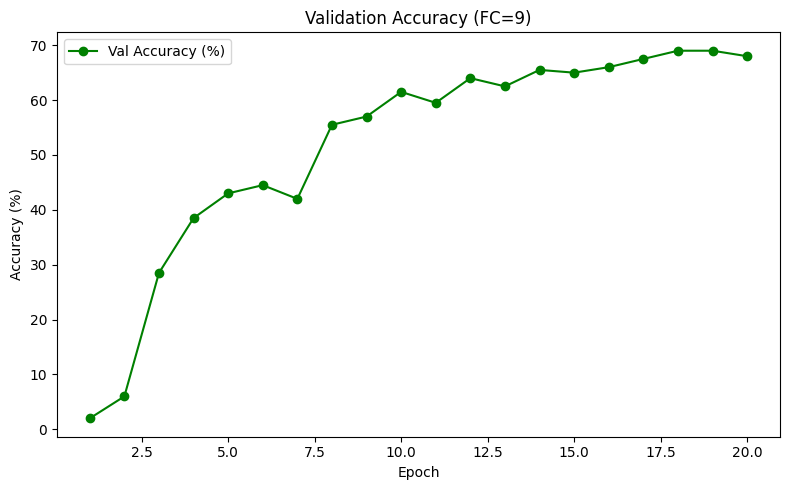

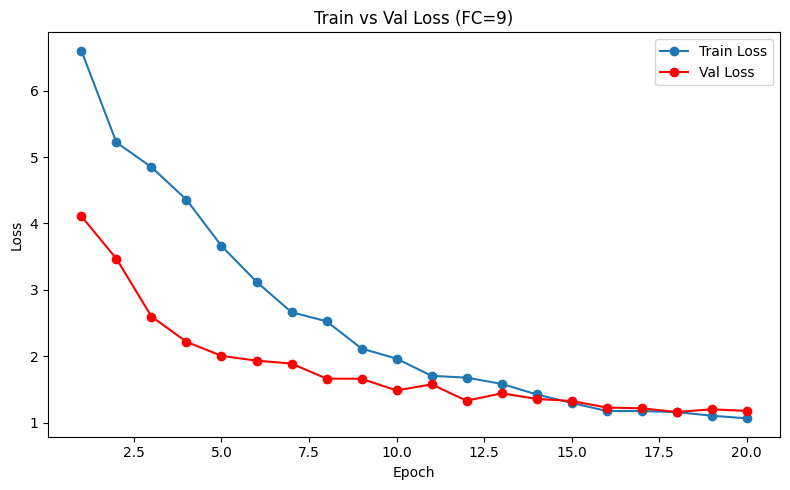

Final Test Accuracy w/ 9 labeled/class => 71.00%


=== SequenceMatch with 17 labeled/class ===


17_PerClass_SeqMatch Epoch[1/20] TrainLoss=5.8504, Sup=4.3000, Unsup=1.9379, TrainAcc=1.76% ValLoss=3.9039, ValAcc=2.50%


17_PerClass_SeqMatch Epoch[2/20] TrainLoss=5.0560, Sup=3.3005, Unsup=2.1943, TrainAcc=13.65% ValLoss=2.6704, ValAcc=29.50%


17_PerClass_SeqMatch Epoch[3/20] TrainLoss=4.0592, Sup=2.4704, Unsup=1.9860, TrainAcc=31.06% ValLoss=2.2411, ValAcc=41.50%


17_PerClass_SeqMatch Epoch[4/20] TrainLoss=3.3017, Sup=1.9006, Unsup=1.7513, TrainAcc=45.65% ValLoss=1.9508, ValAcc=49.50%


17_PerClass_SeqMatch Epoch[5/20] TrainLoss=2.7896, Sup=1.5032, Unsup=1.6080, TrainAcc=55.29% ValLoss=1.8127, ValAcc=49.00%


17_PerClass_SeqMatch Epoch[6/20] TrainLoss=2.4108, Sup=1.2439, Unsup=1.4587, TrainAcc=62.00% ValLoss=1.5581, ValAcc=58.50%


17_PerClass_SeqMatch Epoch[7/20] TrainLoss=2.1564, Sup=1.0522, Unsup=1.3803, TrainAcc=67.41% ValLoss=1.5055, ValAcc=60.00%


17_PerClass_SeqMatch Epoch[8/20] TrainLoss=1.9027, Sup=0.9128, Unsup=1.2374, TrainAcc=73.53% ValLoss=1.2867, ValAcc=65.00%


17_PerClass_SeqMatch Epoch[9/20] TrainLoss=1.6992, Sup=0.7261, Unsup=1.2164, TrainAcc=78.00% ValLoss=1.5390, ValAcc=61.50%


17_PerClass_SeqMatch Epoch[10/20] TrainLoss=1.5010, Sup=0.6920, Unsup=1.0112, TrainAcc=78.35% ValLoss=1.1492, ValAcc=68.50%


17_PerClass_SeqMatch Epoch[11/20] TrainLoss=1.3438, Sup=0.5060, Unsup=1.0473, TrainAcc=85.53% ValLoss=1.0617, ValAcc=73.50%


17_PerClass_SeqMatch Epoch[12/20] TrainLoss=1.2545, Sup=0.4737, Unsup=0.9761, TrainAcc=88.47% ValLoss=0.9973, ValAcc=73.00%


17_PerClass_SeqMatch Epoch[13/20] TrainLoss=1.0514, Sup=0.3359, Unsup=0.8944, TrainAcc=91.29% ValLoss=0.9922, ValAcc=74.50%


17_PerClass_SeqMatch Epoch[14/20] TrainLoss=1.0499, Sup=0.3080, Unsup=0.9274, TrainAcc=92.00% ValLoss=0.9893, ValAcc=75.00%


17_PerClass_SeqMatch Epoch[15/20] TrainLoss=0.9621, Sup=0.2464, Unsup=0.8946, TrainAcc=94.00% ValLoss=0.9287, ValAcc=74.00%


17_PerClass_SeqMatch Epoch[16/20] TrainLoss=0.8423, Sup=0.2217, Unsup=0.7757, TrainAcc=94.24% ValLoss=0.8081, ValAcc=78.50%


17_PerClass_SeqMatch Epoch[17/20] TrainLoss=0.7551, Sup=0.1909, Unsup=0.7053, TrainAcc=95.88% ValLoss=0.7706, ValAcc=76.00%


17_PerClass_SeqMatch Epoch[18/20] TrainLoss=0.7513, Sup=0.1811, Unsup=0.7128, TrainAcc=96.59% ValLoss=0.7729, ValAcc=77.00%


17_PerClass_SeqMatch Epoch[19/20] TrainLoss=0.7720, Sup=0.1623, Unsup=0.7621, TrainAcc=97.29% ValLoss=0.7745, ValAcc=77.50%


17_PerClass_SeqMatch Epoch[20/20] TrainLoss=0.6857, Sup=0.1599, Unsup=0.6572, TrainAcc=96.71% ValLoss=0.7505, ValAcc=76.50%

17_PerClass_SeqMatch --- Final Test Results ---
Test Accuracy: 79.50%
ROC AUC: 0.9949, Average Precision (AUC-PRC): 0.9024

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.67      0.50      0.57         4
       breathing       0.75      0.75      0.75         4
  brushing_teeth       1.00      1.00      1.00         4
     can_opening       1.00      1.00      1.00         4
        car_horn       1.00      0.75      0.86         4
             cat       1.00      1.00      1.00         4
        chainsaw       0.60      0.75      0.67         4
  chirping_birds       1.00      1.00      1.00         4
    church_bells       1.00      1.00      1.00         4
        clapping       0.80      1.00      0.89         4
     clock_alarm       1.00      0.75      0.86         4
      clock_tick       0.75    

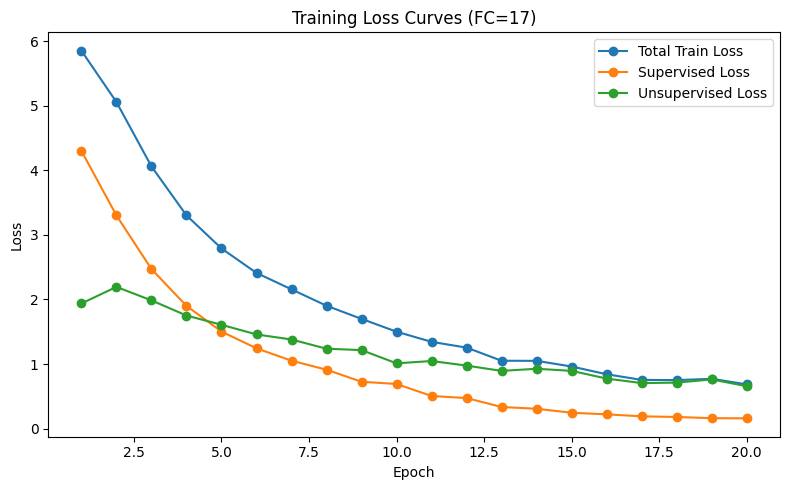

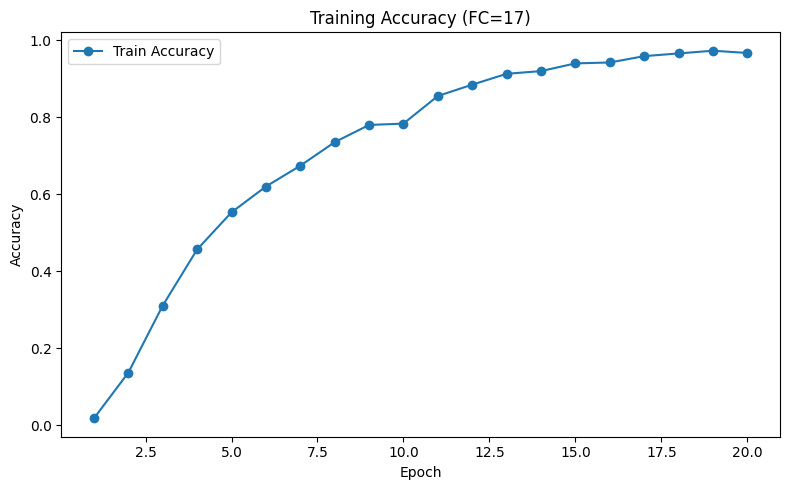

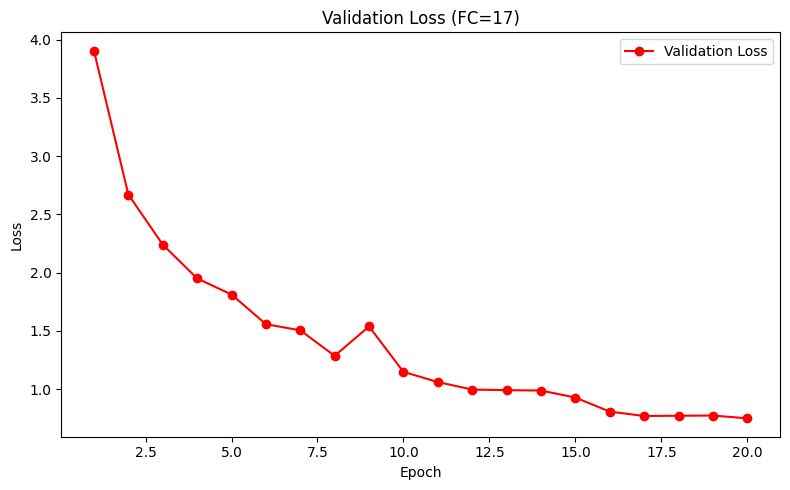

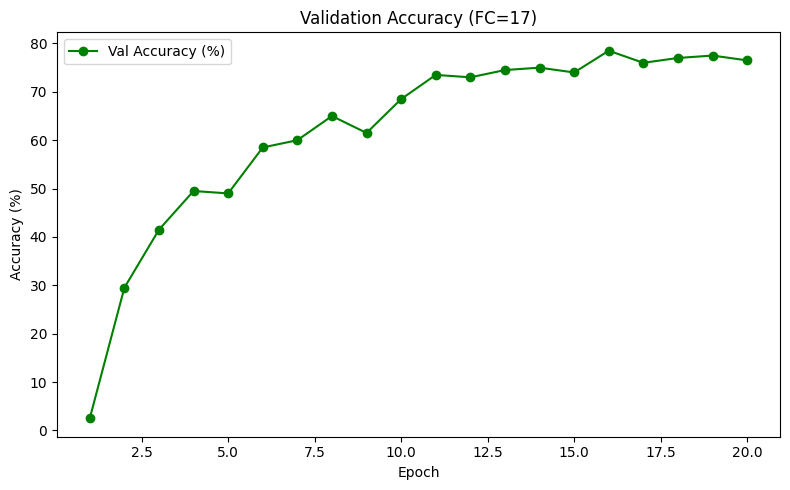

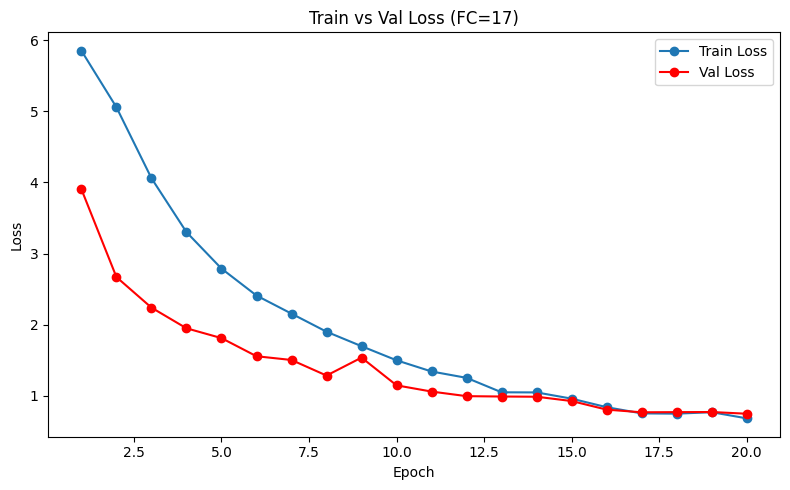

Final Test Accuracy w/ 17 labeled/class => 79.50%


=== SequenceMatch with 26 labeled/class ===


26_PerClass_SeqMatch Epoch[1/20] TrainLoss=5.8465, Sup=4.0243, Unsup=2.2778, TrainAcc=3.46% ValLoss=3.0391, ValAcc=17.50%


26_PerClass_SeqMatch Epoch[2/20] TrainLoss=4.4480, Sup=2.6598, Unsup=2.2352, TrainAcc=28.23% ValLoss=2.5627, ValAcc=31.00%


26_PerClass_SeqMatch Epoch[3/20] TrainLoss=3.3443, Sup=1.9631, Unsup=1.7265, TrainAcc=44.31% ValLoss=1.9092, ValAcc=46.50%


26_PerClass_SeqMatch Epoch[4/20] TrainLoss=2.7337, Sup=1.5603, Unsup=1.4668, TrainAcc=54.77% ValLoss=1.5819, ValAcc=60.00%


26_PerClass_SeqMatch Epoch[5/20] TrainLoss=2.2435, Sup=1.2092, Unsup=1.2929, TrainAcc=63.31% ValLoss=1.2194, ValAcc=61.00%


26_PerClass_SeqMatch Epoch[6/20] TrainLoss=1.8269, Sup=0.9464, Unsup=1.1006, TrainAcc=69.62% ValLoss=1.1577, ValAcc=71.00%


26_PerClass_SeqMatch Epoch[7/20] TrainLoss=1.6074, Sup=0.7921, Unsup=1.0191, TrainAcc=74.69% ValLoss=0.9922, ValAcc=71.50%


26_PerClass_SeqMatch Epoch[8/20] TrainLoss=1.4071, Sup=0.7308, Unsup=0.8454, TrainAcc=78.38% ValLoss=1.0286, ValAcc=70.50%


26_PerClass_SeqMatch Epoch[9/20] TrainLoss=1.1883, Sup=0.5506, Unsup=0.7971, TrainAcc=83.77% ValLoss=0.7589, ValAcc=79.50%


26_PerClass_SeqMatch Epoch[10/20] TrainLoss=1.1034, Sup=0.5565, Unsup=0.6836, TrainAcc=83.08% ValLoss=0.9683, ValAcc=73.50%


26_PerClass_SeqMatch Epoch[11/20] TrainLoss=0.8890, Sup=0.3477, Unsup=0.6766, TrainAcc=88.69% ValLoss=0.7715, ValAcc=78.50%


26_PerClass_SeqMatch Epoch[12/20] TrainLoss=0.7707, Sup=0.2746, Unsup=0.6201, TrainAcc=91.62% ValLoss=0.8310, ValAcc=77.00%


26_PerClass_SeqMatch Epoch[13/20] TrainLoss=0.6525, Sup=0.2524, Unsup=0.5001, TrainAcc=93.31% ValLoss=0.7113, ValAcc=79.00%


26_PerClass_SeqMatch Epoch[14/20] TrainLoss=0.5452, Sup=0.1935, Unsup=0.4396, TrainAcc=95.23% ValLoss=0.6837, ValAcc=82.50%


26_PerClass_SeqMatch Epoch[15/20] TrainLoss=0.4985, Sup=0.1769, Unsup=0.4021, TrainAcc=95.23% ValLoss=0.7374, ValAcc=81.00%


26_PerClass_SeqMatch Epoch[16/20] TrainLoss=0.4323, Sup=0.1387, Unsup=0.3671, TrainAcc=96.08% ValLoss=0.5946, ValAcc=84.00%


26_PerClass_SeqMatch Epoch[17/20] TrainLoss=0.4028, Sup=0.1099, Unsup=0.3662, TrainAcc=97.62% ValLoss=0.5502, ValAcc=85.00%


26_PerClass_SeqMatch Epoch[18/20] TrainLoss=0.3521, Sup=0.0935, Unsup=0.3232, TrainAcc=98.23% ValLoss=0.6287, ValAcc=80.50%


26_PerClass_SeqMatch Epoch[19/20] TrainLoss=0.2887, Sup=0.0635, Unsup=0.2815, TrainAcc=99.15% ValLoss=0.7084, ValAcc=79.50%


26_PerClass_SeqMatch Epoch[20/20] TrainLoss=0.3174, Sup=0.0751, Unsup=0.3029, TrainAcc=99.08% ValLoss=0.6464, ValAcc=83.00%

26_PerClass_SeqMatch --- Final Test Results ---
Test Accuracy: 78.50%
ROC AUC: 0.9943, Average Precision (AUC-PRC): 0.9016

Classification Report:
                  precision    recall  f1-score   support

        airplane       1.00      0.50      0.67         4
       breathing       0.60      0.75      0.67         4
  brushing_teeth       1.00      1.00      1.00         4
     can_opening       1.00      0.75      0.86         4
        car_horn       1.00      0.50      0.67         4
             cat       1.00      1.00      1.00         4
        chainsaw       1.00      1.00      1.00         4
  chirping_birds       1.00      0.75      0.86         4
    church_bells       1.00      1.00      1.00         4
        clapping       1.00      0.75      0.86         4
     clock_alarm       1.00      0.75      0.86         4
      clock_tick       1.00    

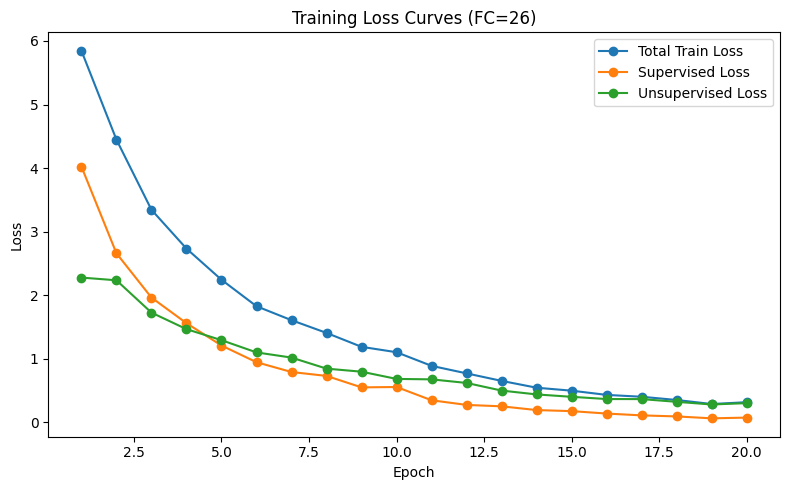

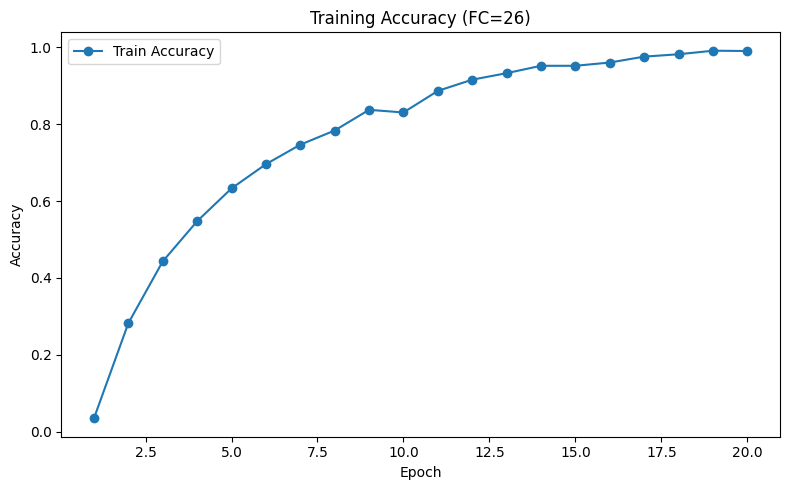

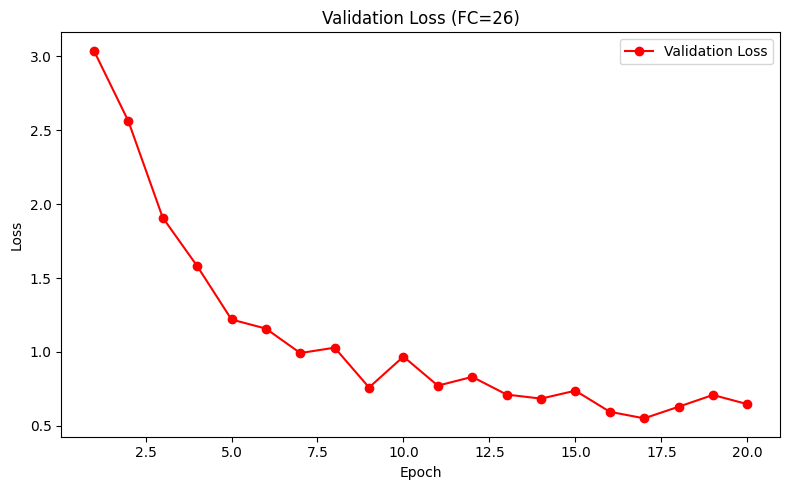

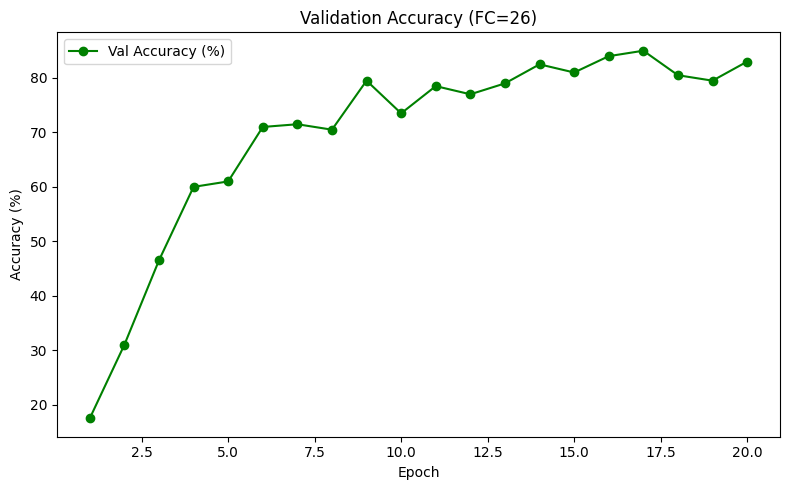

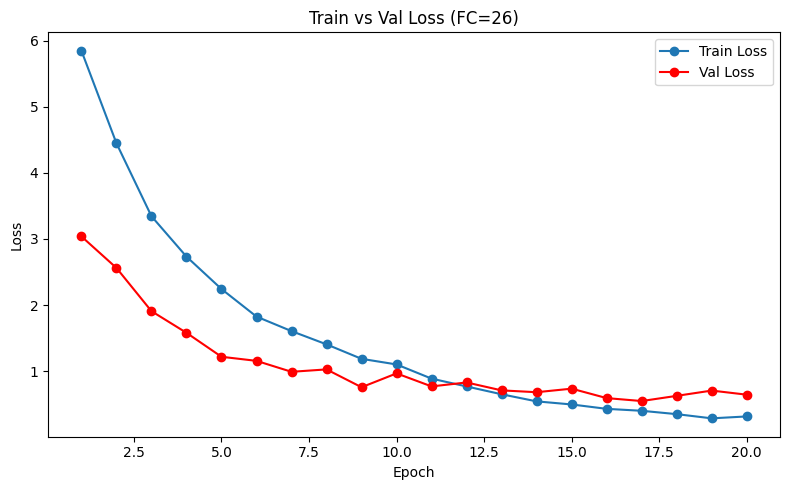

Final Test Accuracy w/ 26 labeled/class => 78.50%

===== SUMMARY OF RUNS =====
5 labeled/class: TestAcc=56.00% | ValAcc(final)=49.50%
9 labeled/class: TestAcc=71.00% | ValAcc(final)=68.00%
17 labeled/class: TestAcc=79.50% | ValAcc(final)=76.50%
26 labeled/class: TestAcc=78.50% | ValAcc(final)=83.00%


In [ ]:
if __name__=="__main__":
    from multiprocessing import freeze_support
    freeze_support()
    Main()